In [1]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
import keras
import cv2
import os

load images

In [2]:
no_path = '../archive/brain_tumor_dataset/no'
yes_path = '../archive/brain_tumor_dataset/yes'
images = []
labels = [] # label 0 is no tumor, label 1 tumor occurs
for path in (no_path, yes_path):
    if path == no_path:
        default_label = 0
    elif path == yes_path:
        default_label = 1
    else:
        raise(Exception("What's going on?? No such file or directory"))
    
    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)
        
        img = cv2.imread(img_path)
        
        # resize to convenient shape for CNN's
        img = cv2.resize(img, (224,224))
        
        # # cnn's need shape in rgb format, so i repeat one layer to 3
        # img = np.repeat(img, 3, axis=-1)
        
        images.append(img)
        labels.append(default_label)

images = np.array(images)
labels = np.array(labels)

In [3]:
from sklearn.model_selection import train_test_split
# preprocess images to fit for vgg19
vgg16_images = keras.applications.vgg16.preprocess_input(images)

def split_data(images_list, train_size: float=0.8, random_state: int=112):
    """Prepare data for CNN's. Split data by sklearn.model_selection.train_test_split, convert to np.array type, and categorize labels.

    Args:
        images_list (Iterable): Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
        train_size (float, Optional): Should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. Defaults to 0.8.
        random_state (int, Optional): Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. Defaults to 112.
        
    """
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=train_size, random_state=random_state) # images is raw data without being preprocessed, 
    # optionally load here preprocessed data by cnn's own algorithm instead, for example vgg16_images (every cnn has its own prep. algorithm)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(vgg16_images)

vgg16_base_model = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

for layer in vgg16_base_model.layers:
    layer.trainable = False 
x = keras.layers.Flatten()(vgg16_base_model.output)
x = keras.layers.Dense(2, activation='softmax')(x)  # 2 klasy
vgg16_model = keras.models.Model(inputs=vgg16_base_model.input, outputs=x)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# callback to stop epochs when satisfying outcome
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_recall',  
    patience=3,               
    restore_best_weights=True 
)

# fit data with validation
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
vgg19_predictions = vgg16_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5317 - loss: 17.5881 - recall: 0.5317 - val_accuracy: 0.6667 - val_loss: 7.6033 - val_recall: 0.6667
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.8251 - loss: 4.6828 - recall: 0.8251 - val_accuracy: 0.8824 - val_loss: 1.3116 - val_recall: 0.8824
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9123 - loss: 1.4995 - recall: 0.9123 - val_accuracy: 0.8431 - val_loss: 3.8660 - val_recall: 0.8431
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9395 - loss: 0.8694 - recall: 0.9395 - val_accuracy: 0.9216 - val_loss: 1.7776 - val_recall: 0.9216
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9613 - loss: 0.6028 - recall: 0.9613 - val_accuracy: 0.9216 - val_loss: 1.5441 - val_recall: 0.9216
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9964 - loss: 0.0270 - recall: 0.9964 - val_accuracy: 0.9020 - val_loss: 1.6177 - val_recall: 0.9020
Epoch 7/30
7/7 ━━━━━━━━━━━━

create model of grad cam

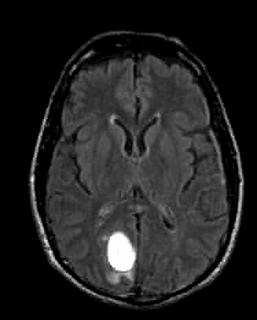

In [40]:


img_size = (224, 224)

decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

## The local path to our target image

img_path= "../archive/test/Y_new.png"

display(Image(img_path))
def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific 
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap of image with model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predykcja dla obrazu: Tumor z pewnością 1409.95%


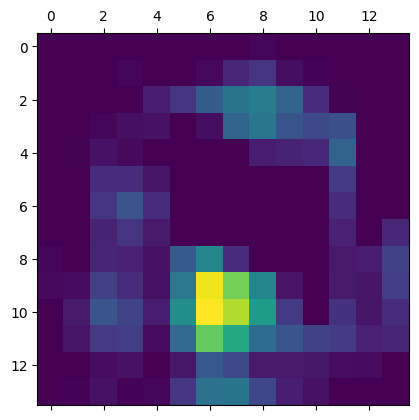

In [41]:
## Preparing the image
img_array = keras.applications.vgg16.preprocess_input(get_img_array(img_path, size=img_size))

## Remove last layer's softmax(transfer learning)
vgg16_model.layers[-1].activation = None

preds = vgg16_model.predict(img_array)
class_names = ["No Tumor", "Tumor"]
predicted_class = class_names[np.argmax(preds)]
confidence = np.max(preds) * 100

print(f"Predykcja dla obrazu: {predicted_class} z pewnością {confidence:.2f}%")
## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, vgg16_model, last_conv_layer_name)

## visulization of heatmap
plt.matshow(heatmap)
plt.show()

save and display vis

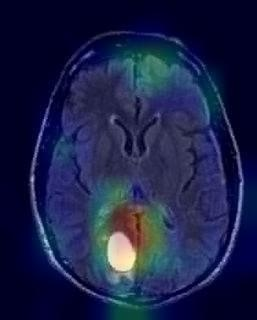

In [42]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)

    ## Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

test class

In [ ]:
from grad_cam import GradCam
from keras.models import load_model

model = load_model('../models/VGG_16.keras')
grad_cam = GradCam(model)

heatmap = grad_cam.compute_heatmap(preprocessed_img,  class_idx=0)
self.image_w_grad_original = self.grad_cam_alg.overlay_heatmap(heatmap, preprocessed_img)
repreprocessed_img = self.preprocess_image(self.image_w_grad_original, reversed_=True)
